In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from common import fetch_data, get_backtest_result, get_hodl_result, max_drawdown, get_cache_path, save_cache_data, load_cache_data

In [2]:
# Fetch and save funding rate and price history

# Input
exchanges_markets = [
    {
        "binance": "BTCUSDT",
        "bitmex": "XBTUSD",
        "apollox": "BTCUSDT",
        "drift": "BTC-PERP"
    },
    {
        "binance": "ETHUSDT",
        "bitmex": "ETHUSD",
        "apollox": "ETHUSDT",
        "drift": "ETH-PERP"
    },
    {
        "binance": "SOLUSDT",
        "bitmex": "SOLUSD",
        "apollox": "SOLUSDT",
        "drift": "SOL-PERP"
    },
    {
        "binance": "XRPUSDT",
        "bitmex": "XRPUSD",
        "apollox": "XRPUSDT",
        "drift": "XRP-PERP"
    },
    {
        "binance": "BNBUSDT",
        "bitmex": "BNBUSD",
        "apollox": "BNBUSDT",
        "drift": "BNB-PERP"
    },
]

accepted_exchanges = ['binance', 'apollox', 'drift']
exchanges_markets = [{key: market[key] for key in market if key in accepted_exchanges } for market in exchanges_markets]

for exchanges_market in exchanges_markets:
    for exchange, market in exchanges_market.items():
         data = fetch_data(exchange, market)
         save_cache_data(exchange, market, data)

Drift BTC-PERP Error: 403
Drift BTC-PERP Error: 403
Drift BTC-PERP Error: 403
Drift BTC-PERP Error: 403
Drift ETH-PERP Error: 403
Drift ETH-PERP Error: 403
Drift ETH-PERP Error: 403
Drift ETH-PERP Error: 403
Drift SOL-PERP Error: 403
Drift SOL-PERP Error: 403
Drift SOL-PERP Error: 403
Drift SOL-PERP Error: 403
Drift XRP-PERP Error: 403
Drift XRP-PERP Error: 403
Drift XRP-PERP Error: 403
Drift XRP-PERP Error: 403
Drift XRP-PERP Error: 403


/Users/sainy/Documents/projects/funding/funding-arb-analysis/modules/exchanges/drift.py:141: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['0.508083' '0.509823' '0.501084' '0.492326' '0.503000' '0.500399'
 '0.505067' '0.504090' '0.506612' '0.507223' '0.500237' '0.503329'
 '0.501865' '0.495548' '0.500456' '0.505715' '0.504593' '0.504343'
 '0.497976' '0.476500' '0.482167' '0.471022' '0.470093' '0.472774'
 '0.481084' '0.475924' '0.482634' '0.484351' '0.487391' '0.492524'
 '0.491450' '0.500630' '0.505665' '0.498483' '0.496870' '0.493539'
 '0.503101' '0.499848' '0.501213' '0.499922' '0.501212' '0.501635'
 '0.498696' '0.498198' '0.489739' '0.496648' '0.501774' '0.503577'
 '0.502170' '0.503324' '0.502273' '0.511347' '0.507427' '0.505870'
 '0.506179' '0.508323' '0.510100' '0.509640' '0.511753' '0.513463'
 '0.514741' '0.517172' '0.524771' '0.516258' '0.515114' '0.516058'
 '0.519976' '0.514339' '0.517019' '0.517425' '0.5117

Drift BNB-PERP Error: 403
Drift BNB-PERP Error: 403
Drift BNB-PERP Error: 403
Drift BNB-PERP Error: 403


In [3]:
# Compute funding rate PNL with only one market
exchanges_market = {
    "binance": "BTCUSDT",
    # "bitmex": "XBTUSD",
    "apollox": "BTCUSDT",
    "drift": "BTC-PERP",
}
benchmark_exchange = "binance"

# Initial variables
min_time = 0
max_time = datetime.now().timestamp()

data_df_map = {}
results = {}

leverage = 1

# Read data from file
for exchange, market in exchanges_market.items():
    data_df = pd.read_csv(f"./data/{exchange}_{market}.csv")
    data_df_map[exchange] = data_df

# calculate min max time
for exchange, market in exchanges_market.items():
    data_df = data_df_map[exchange]
    min_time = max(min_time, data_df["timestamp"].min())
    max_time = min(max_time, data_df["timestamp"].max())

# Calculate funding rate backtest result
for exchange, market in exchanges_market.items():
    data_df = data_df_map[exchange]
    data_df['datetime'] = data_df['datetime'].apply(lambda x: pd.to_datetime(x))

    data_df = data_df[
        (data_df["timestamp"] >= min_time) & (data_df["timestamp"] <= max_time)
    ]

    data_df = data_df.sort_values(by='datetime', ascending=True)
    data_df = data_df.reset_index(drop=True)

    result_df = get_backtest_result(data_df, leverage)
    results[exchange] = result_df

hodl_df = get_hodl_result(results[benchmark_exchange])

# Results are store in 'results' and 'hodl_df' variables

/Users/sainy/Documents/projects/funding/funding-arb-analysis/common.py:89: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.999' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index, 'clt'] = max(new_clt, 0)
/Users/sainy/Documents/projects/funding/funding-arb-analysis/common.py:91: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28350.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index, 'entry'] = price if traded else prev_df['entry']
/Users/sainy/Documents/projects/funding/funding-arb-analysis/common.py:93: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '28322.1495' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[index, 'pos_size'

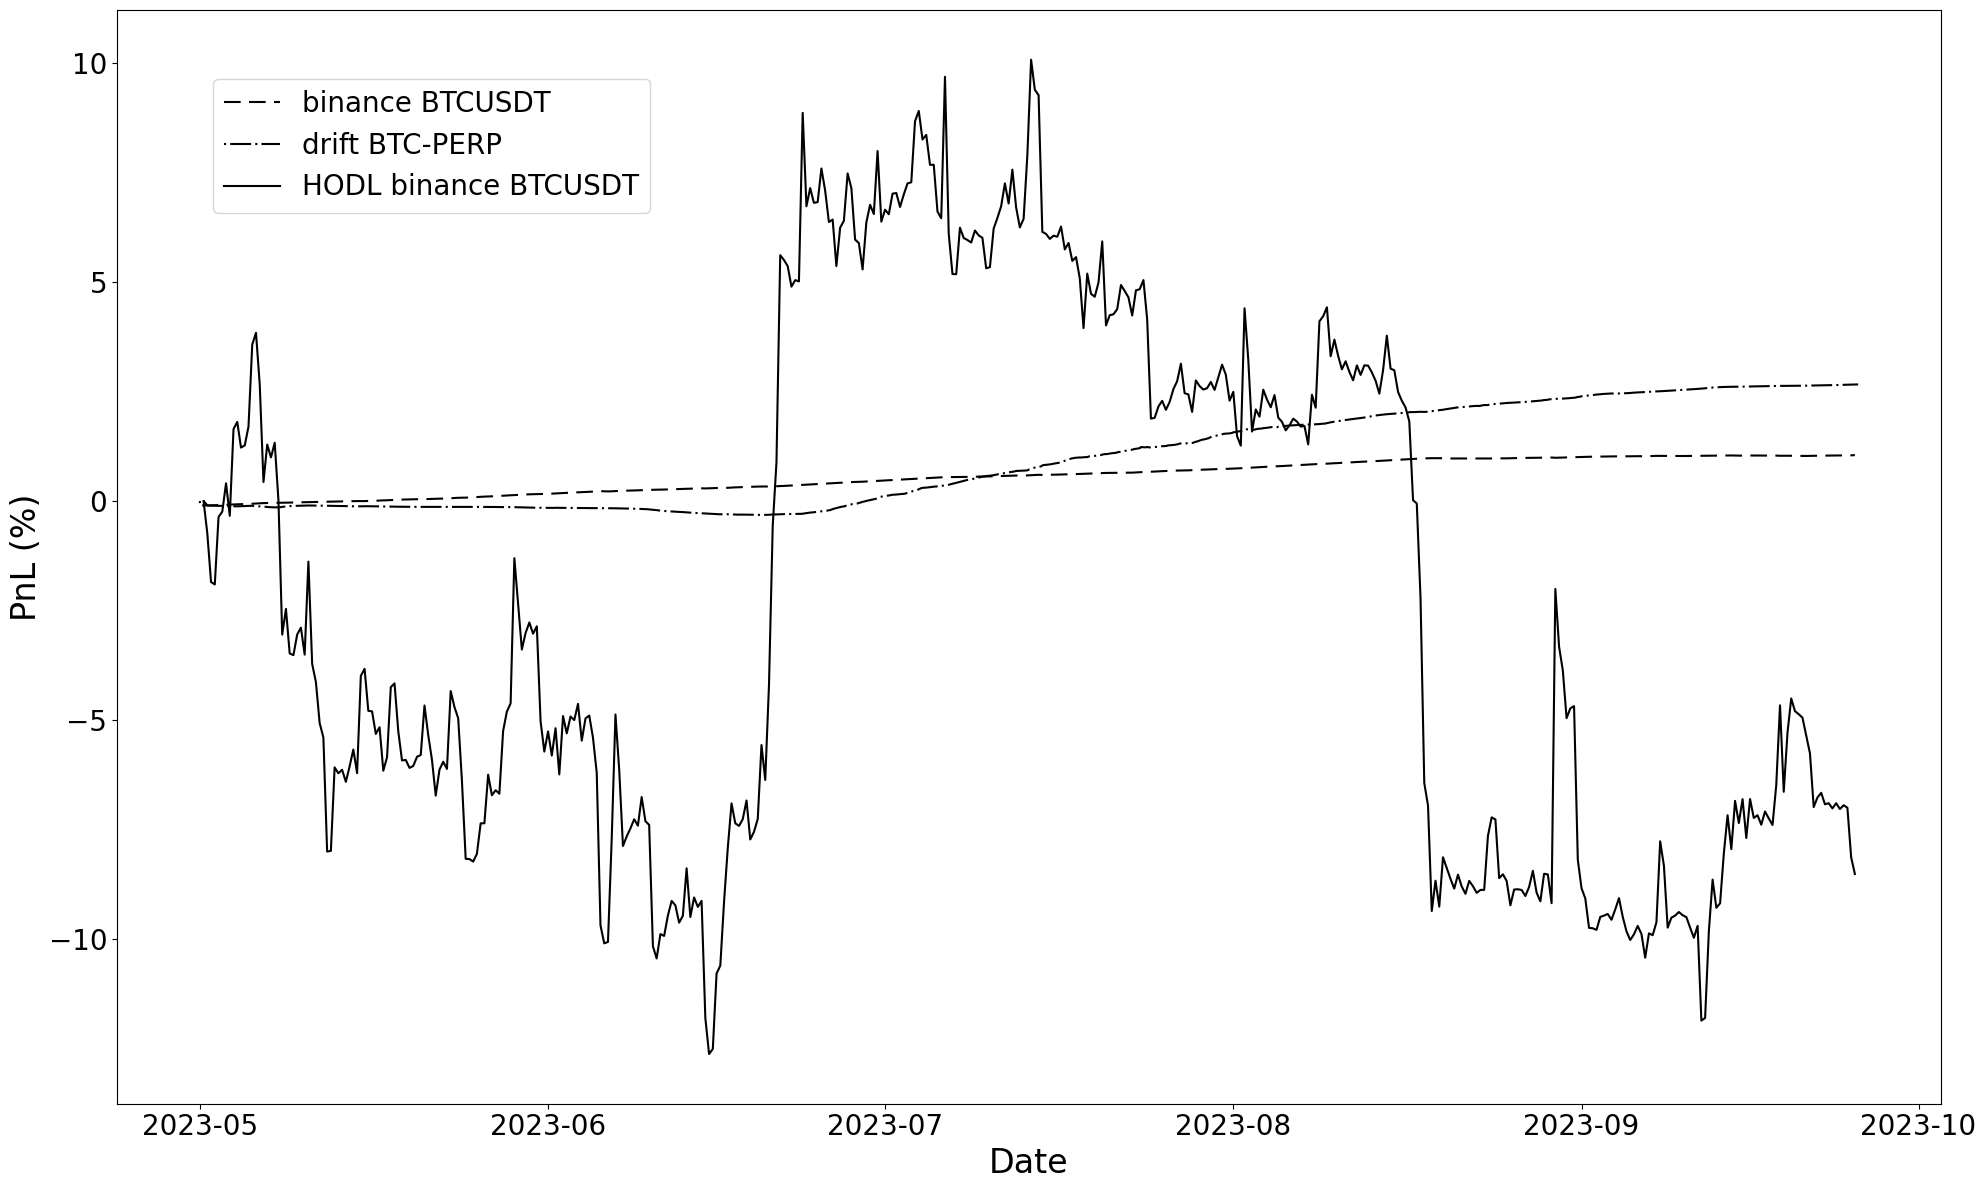

In [4]:
# Plot funding rate arb PNL with HODL PNL
exchanges_market = {
    "binance": "BTCUSDT",
    # "bitmex": "XBTUSD",
    "drift": "BTC-PERP"
}
line_styles = {"binance": "--", "bitmex": ":", "apollox": "--", "drift": "-."}
dash_styles = {"binance": [8, 4], "bitmex": [1, 3], "apollox": [8, 4], "drift":[1, 2, 10, 2]}
hodl_line_style = "-"
hodl_dash_style = []

fig, ax = plt.subplots(figsize=(20, 12))

# Plot funding arb result
for exchange, market in exchanges_market.items():
    result_df = results[exchange]
    line,  = ax.plot(
        result_df["datetime"],
        result_df["final_pnl"] * 100,
        label=f"{exchange} {market}",
        linestyle=line_styles[exchange],
        color="black",
    )
    line.set_dashes(dash_styles[exchange])

# Plot hodl result
ax.plot(hodl_df['datetime'], hodl_df['pnl'] * 100, label=f'HODL binance BTCUSDT', linestyle=hodl_line_style, dashes=hodl_dash_style, color='black')

# Chart settings
lines, labels = ax.get_legend_handles_labels()
plt.xlabel("Date", fontsize=24)
plt.ylabel("PnL (%)", fontsize=24)
ax.legend(lines, labels, loc="upper right", bbox_to_anchor=(0.3, 0.95), fontsize=20)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Ensure a tight layout to avoid label/legend clipping
plt.tight_layout()

plt.savefig('./images/basic_funding_hodl_pnl.png', format='png', dpi=300, bbox_inches='tight')

plt.show()